<a href="https://colab.research.google.com/github/SEAS-CVN/SEAS-2025/blob/main/Projects/FishID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Giới thiệu (Intro)

> Một hệ thống học máy tối ưu cho thiết bị biên (edge-optimized machine learning system) nhằm nhận diện theo thời gian thực (real-time identification) các loài cá bản địa tại Đồng Hới, Quảng Bình. Dự án này ứng dụng thị giác máy tính (computer vision) và các kiến trúc học máy hiệu quả (efficient ML architectures) để phân loại cá chính xác trên phần cứng có tài nguyên hạn chế (resource-constrained hardware).

**Đồng Hới** là một thành phố ven biển ở miền Trung Việt Nam, nổi tiếng với ngành thủy sản phát triển mạnh và hệ sinh thái biển đa dạng. Việc nhận diện chính xác và hiệu quả các loài cá đóng vai trò quan trọng trong:

* Hỗ trợ các phương pháp đánh bắt bền vững (sustainable fishing practices)

* Giám sát môi trường và bảo tồn sinh thái (environmental monitoring and conservation)

* Kiểm soát chất lượng trong chế biến thủy sản (quality control in seafood processing)

* Nghiên cứu khoa học về hệ sinh thái biển địa phương (scientific research on local marine ecosystems)

Phương pháp nhận diện truyền thống dựa vào quan sát của chuyên gia (expert visual inspection), vốn có nhiều hạn chế về tốc độ, tính nhất quán (consistency) và khả năng ứng dụng theo thời gian thực (real-time application).

Dự án này hướng tới việc phát triển một giải pháp học máy theo thời gian thực (real-time machine learning solution) nhằm:

* Nhận diện chính xác các loài cá từ dữ liệu hình ảnh (visual data)

* Vận hành hiệu quả trên các thiết bị biên tiêu thụ năng lượng thấp (low-power edge devices) như bộ tăng tốc FPGA (FPGA accelerators), hệ thống nhúng (embedded systems)

* Hoạt động đáng tin cậy trong môi trường biển khắc nghiệt (challenging marine environments)

* Cung cấp giao diện dễ tiếp cận (accessible interface) cho nhiều đối tượng sử dụng (stakeholders)

### Ứng dụng:

* Tàu nghiên cứu biển (marine research vessels)

* Tự động hóa trong ngành đánh bắt thủy sản (fishing industry automation)

* Robot giám sát đại dương và phương tiện ngầm tự hành (ocean-monitoring robots and autonomous underwater vehicles)

* Hoạt động bảo tồn môi trường biển (environmental conservation efforts)

* Công cụ giáo dục về đa dạng sinh học biển (educational tools for marine biodiversity)

## Dữ Liệu

Trong dự án này, bọn mình sẽ dùng dữ liệu từ [FishNet](https://github.com/faixan-khan/FishNet/?tab=readme-ov-file)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import os
import zipfile

# --- Configuration ---
# Adjust this path to where you added the shortcut in your 'My Drive'
# Example: If you added the shortcut directly into 'My Drive'
zip_file_path_in_drive = '/content/drive/MyDrive/fishnet.zip'
# Example: If you added it inside a folder called 'SharedStuff' in 'My Drive'
# zip_file_path_in_drive = '/content/drive/MyDrive/SharedStuff/your_shared_file.zip'

# Choose a directory within Colab's temporary storage to extract the files
extract_to_directory = '/content/extracted_data'
# --- End Configuration ---

# Check if the zip file exists at the specified path
if not os.path.exists(zip_file_path_in_drive):
  print(f"Error: Zip file not found at '{zip_file_path_in_drive}'")
  print("Please double-check the path and ensure you've added the shortcut to your Drive.")
else:
  print(f"Zip file found at: {zip_file_path_in_drive}")

  # Create the extraction directory if it doesn't exist
  os.makedirs(extract_to_directory, exist_ok=True)
  print(f"Extracting files to: {extract_to_directory}")

  # Unzip the file
  try:
    with zipfile.ZipFile(zip_file_path_in_drive, 'r') as zip_ref:
      zip_ref.extractall(extract_to_directory)
    print("Extraction complete.")

    # List the extracted files (optional)
    print("\nExtracted files:")
    for item in os.listdir(extract_to_directory):
        print(f"- {item}")

  except zipfile.BadZipFile:
    print(f"Error: The file at '{zip_file_path_in_drive}' is not a valid zip file or is corrupted.")
  except Exception as e:
    print(f"An error occurred during extraction: {e}")

# You can now work with the files in '/content/extracted_data'

Zip file found at: /content/drive/MyDrive/fishnet.zip
Extracting files to: /content/extracted_data
Extraction complete.

Extracted files:
- Image_Library
- anns


In [10]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path settings
image_root = '/content/extracted_data/Image_Library'
csv_output_dir = '/content/extracted_data/anns'
os.makedirs(csv_output_dir, exist_ok=True)

# Step 1: Collect image metadata
data = []
for folder in os.listdir(image_root):
    folder_path = os.path.join(image_root, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append({
                    "image": img_file,
                    "Folder": folder,
                    "Family": folder  # Folder name as class label
                })

df = pd.DataFrame(data)

# Step 2: Remove classes with fewer than 2 samples
counts = df["Family"].value_counts()
valid_classes = counts[counts >= 2].index.tolist()
df = df[df["Family"].isin(valid_classes)]
df = df.sample(frac=1, random_state=42)  # Shuffle

print(f"✅ Total valid images after removing small classes: {len(df)}")
print(f"📦 Remaining classes: {len(valid_classes)}")

# Step 3: Stratified train/test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Family"],
    random_state=42
)

# Step 4: Save to CSV
train_df.to_csv(os.path.join(csv_output_dir, 'train.csv'), index=False)
test_df.to_csv(os.path.join(csv_output_dir, 'test.csv'), index=False)

print(f"✅ Saved train.csv ({len(train_df)} samples), test.csv ({len(test_df)} samples)")


✅ Total valid images after removing small classes: 94768
📦 Remaining classes: 533
✅ Saved train.csv (75814 samples), test.csv (18954 samples)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from tqdm import tqdm

# 1. Tiny CNN model (fast on CPU)
class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Flatten(),
            nn.Linear(16 * 56 * 56, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# 2. Simple dataset class
class SimpleImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform, class_to_index):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_index = class_to_index

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_path = os.path.join(self.root_dir, row['Folder'], row['image'])
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_index[row['Family']]
        return self.transform(image), label

# 3. Config paths and label map
img_root = '/content/extracted_data/Image_Library'
train_csv = '/content/extracted_data/anns/train.csv'
test_csv = '/content/extracted_data/anns/test.csv'

df = pd.read_csv(train_csv)
class_to_index = {label: i for i, label in enumerate(sorted(df['Family'].unique()))}
n_classes = len(class_to_index)

# 4. Transforms
transform = transforms.Compose([
    transforms.Resize(256),           # Resize shorter side to 256
    transforms.CenterCrop(224),       # Crop the center 224×224
    transforms.ToTensor()
])

# 5. Data loaders
train_dataset = SimpleImageDataset(train_csv, img_root, transform, class_to_index)
test_dataset = SimpleImageDataset(test_csv, img_root, transform, class_to_index)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 6. Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 7. Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"✅ Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"🎯 Accuracy: {100 * correct / total:.2f}%\n")


Epoch 1/3: 100%|██████████| 4739/4739 [08:34<00:00,  9.21it/s]


✅ Epoch 1 Loss: 4.4492
🎯 Accuracy: 11.38%



Epoch 2/3: 100%|██████████| 4739/4739 [08:20<00:00,  9.48it/s]


✅ Epoch 2 Loss: 3.9998
🎯 Accuracy: 14.95%



Epoch 3/3: 100%|██████████| 4739/4739 [07:48<00:00, 10.11it/s]


✅ Epoch 3 Loss: 3.7283
🎯 Accuracy: 14.76%



In [12]:
save_path = '/content/drive/MyDrive/fish_model_full.pth'
torch.save(model, save_path)

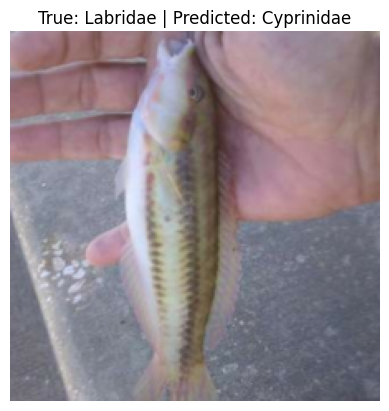

In [17]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

# 1. Load label mapping (used for decoding class index)
index_to_class = {v: k for k, v in class_to_index.items()}

# 2. Pick a random sample from the test dataset
model.eval()
rand_index = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[rand_index]

# 3. Prepare input
image_input = image.unsqueeze(0).to(device)  # add batch dimension

# 4. Predict
with torch.no_grad():
    output = model(image_input)
    predicted_index = torch.argmax(output, dim=1).item()

# 5. Decode class labels
true_class = index_to_class[true_label]
predicted_class = index_to_class[predicted_index]

# 6. Display image and prediction
plt.imshow(ToPILImage()(image))
plt.axis('off')
plt.title(f'True: {true_class} | Predicted: {predicted_class}')
plt.show()


# Bigger pre-trained model

In [ ]:
from torchvision import transforms, models

# 8. Model (ResNet50 or another from timm)
# Option A: torchvision
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, n_classes)

# # Option B: uncomment to use timm
# import timm
# model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)

model = model.to(device)

# 9. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# 10. Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"✅ Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"🎯 Validation Accuracy: {acc:.2f}%\n")

# 11. Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/fish_model_resnet50.pth')
print("✅ Model saved to Google Drive.")

Epoch 1/5:  10%|█         | 484/4739 [02:04<19:48,  3.58it/s]

# Deploying on Edge Device